<table style="width: 100%">
    <tr style="background: #ffffff">
        <td style="padding-top:25px; width: 180px">
            <img src="https://mci.edu/templates/mci/images/logo.svg" alt="Logo">
        </td>
        <td style="width: 100%">
            <div style="width: 100%; text-align:right"><font style="font-size:38px"><b>Softwaredesign</b></font></div>
            <div style="padding-top:0px; width: 100%; text-align:right"><font size="4"><b>Mechatronik</b></font></div>
        </td>
    </tr>
</table>

---

# Travelable Distance - Fahrreichweiten-Simulation
Die Flotte an Logistikfahrzeugen Ihres Arbeitgebers soll erneuert werden. Nun stellt sich die große Frage, in welchem Ausmaß Elektro- bzw. Wasserstofffahrzeuge hier sinnvoll eingesetzt werden können.

Sie sollen nun bestimmen welche Reichweite ein solches Fahrzeug haben müsste, um tatsächlich praktikabel zu sein. Da sich das Liefergebiet prinzipiell auf ganz Europa erstreckt, sind Sie nicht mehr in der Lage dieses Problem händisch zu lösen.

Sie sollen daher basierend auf einem Datensatz mit ca. 69500 europäischen Ortschaften und Städten bestimmen wie viele Stopps bei einer Lieferung eingelegt werden müssen, um das Lieferfahrzeug voll zu tanken.

---
## Beginn der Setup-Code-Blöcke

In [2]:
import pandas as pd
from math import radians, sin, asin, cos, atan2, sqrt

### Hilfsfunktion um die Distanz zw. zwei Punkten auf der Erde zu bestimmen
Implementieren Sie die Funktion `distance_on_earth(lat1, lon1, lat2, lon2)` die aus den geographischen Koordinaten zweier Punkte auf der Erde die Distanz in Kilometern berechnet.  
Nutzen Sie hierfür die [Haversine-Formel](https://en.wikipedia.org/wiki/Haversine_formula). Dies ist zwar nur eine Näherungsformel, welche die Erde als perfekte Kugel annimmt, aber das Ergebnis ist für unsere Zwecke ausreichend genau.

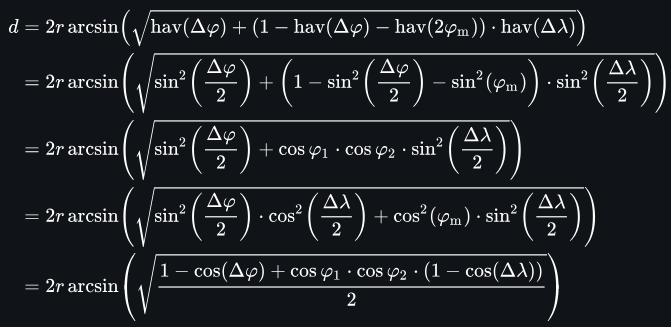

In [3]:
def distance_on_earth(lat1, lon1, lat2, lon2):
    """Calculates distance between two points on earth using the haversine formula."""
    r = 6370

    lat1 = radians(lat1)
    lat2 = radians(lat2)

    lon1 = radians(lon1)
    lon2 = radians(lon2)

    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = sin(delta_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(delta_lon / 2)**2
    c = 2 * asin(sqrt(a))
    d = r * c
    return d

assert 14 < distance_on_earth(47.296464, 11.586556, 47.259659, 11.400375) < 15
distance_on_earth(47.296464, 11.586556, 47.259659, 11.400375)

14.627139939541626

---
### Klasse um eine Stadt zu repräsentieren
Diese Klasse soll in der Lage sein eine Stadt mit deren Namen und Koordinaten zu repärsentierne.  
Weiter müssen zwei Städte auf Gleichheit überprüfbar sein und hier `True` zurück liefern, wenn der Name und die Koordinaten der Städte ident sind.  
Außerdem muss die Klasse hashbar sein, damit sie in einem `dict` gespeichert werden kann.

Ebenso notwendig ist eine Methode `distance_to()` mit der die Distanz zu einer anderen Stadt berechnet werden kann.

In [4]:
class City:
    def __init__(self, name, lat, lon):
        """Erstellt eine neue Stadt mit Namen name, Breitengrad lat und Längengrad lon."""
        self.name = name
        self.lat = lat
        self.lon = lon

    def distance_to(self, other):
        """Berechnet die Distanz einer Stadt zu einer anderen Stadt (übergeben als other) basierend auf der oben implementierten Haversine-Formel."""
        return distance_on_earth(self.lat, self.lon, other.lat, other.lon)
    
    def __eq__(self, other):
        """Hiermit ermöglichen wir es zwei Objekte der Klasse City mit == zu vergleichen. Damit können wir später vermeiden die Distanz zwischen einer Stadt und sich selbst zu berechnen."""
        if not isinstance(other, City): #diese if-Abfrage ist notwendig um ein Problem bei den automatischen Aufrufen aus den networkx-Algorithmen zu vermeiden
            return False
        return self.name == other.name and self.lat == other.lat and self.lon == other.lon
    
    def __hash__(self) -> int:
        """Ein Hash-Wert wird benötigt, um die Stadt als Knoten in einem Graphen zu verwenden. 
        Ein Hash-Wert ist eine Zahl, die eindeutig für jedes Objekt ist und muss also auf Basis aller Attribute der Klasse berechnet werden.
        Im Python gibt es eine eingebaute Funktion hash(), die einen Hash-Wert für verschiedene Objekt berechnet."""
        return hash((self.name, self.lat, self.lon))

    def __str__(self):
        """Gibt z.B. 'Innsbruck' zurück, wenn die Stadt Innsbruck heißt."""
        return f"{self.name}: BG = {self.lat}°, LG = {self.lon}°"
    
    def __repr__(self) -> str:
        return self.__str__()


### Einlesen der CSV-Datei
Hier wird die Datei `cities_in_europe.csv` für Sie eingelesen und die darin enthaltenen Städte in einem Pandas `DateFrame` abgespeichert.  
Verschaffen Sie sich einen überblick darüber wie die Daten aufgebaut sind.

In [5]:
df = pd.read_csv('cities_in_europe.csv', sep=';', encoding='latin1')
df.head()

,ASCII Name,Country name EN,Country Code,Population,LABEL EN,Coordinates,Latitude,Longitude
0,Istanbul,Turkey,TR,14804116,Turkey,"41.01384, 28.94966",41.01384,28.94966
1,Moscow,Russian Federation,RU,10381222,Russian Federation,"55.75222, 37.61556",55.75222,37.61556
2,London,United Kingdom,GB,8961989,United Kingdom,"51.50853, -0.12574",51.50853,-0.12574
3,Saint Petersburg,Russian Federation,RU,5351935,Russian Federation,"59.93863, 30.31413",59.93863,30.31413
4,Ankara,Turkey,TR,3517182,Turkey,"39.91987, 32.85427",39.91987,32.85427


---
### Aufbau eines Graphen
Um unsere Daten sinnvoll miteinander in Verbindung zu bringen muss eine geeignete Datenstruktur für das Problem gewählt werden.  
In diesem Fall wird das ein Graph sein, welchen wir mittels `networkx`-Modul implementieren.

In [6]:
import networkx as nx

### Knoten des Graphen hinzufügen
Erstellen Sie einen neuen Graphen und fügen Sie die ersten `amount_of_cities` Städte hinzu. Städte sollen dabei immer als `City`-Objekt repräsentiert werden.  
Hierfür können Sie die `add_node(...)`-Methode des Graphen verwenden, wie sie in der [Vorlesung vorgestellt](https://mrp123.github.io/MCI-MECH-B-3-SWD-SWD-ILV/03_Algorithmen_und_Datenstrukturen/Examples/B%C3%A4ume_und_Graphen/networkx_example.py) wurde. Für genauere Informationen können Sie auch die [Dokumentation von `networkx`](https://networkx.org/documentation/stable/reference/classes/graph.html) zu Rate ziehen.

In [7]:
graph = nx.Graph()

# Beschränken Sie die Anzahl der Städte auf 4000, um die Berechnung zu beschleunigen
amount_of_cities = 4000

# Lösung hier einfügen

## Sie müssen zuerst die Daten aus dem DataFrame nutzen, um diese als City-Objekte zu erstellen

## Diese müssen Sie die Städte als Knoten zum Graphen hinzufügen
for i in range(amount_of_cities):
    graph.add_node(City(df.loc[i]["ASCII Name"], 
                        df.loc[i]["Latitude"], 
                        df.loc[i]["Longitude"])
                    )

# Ende der Lösung

# Check ob die richtige Anzahl an Städten hinzugefügt wurde --> kommt nach der Implementierung
assert amount_of_cities == len(graph.nodes)

---
### Kanten des Graphen hinzufügen
Wir können nun über die Knoten des Graphen iterieren und daraus die Distanze zwischen allen Städten bestimmen. Wir nehmen an, dass zwei Städte miteinander verbunden werden können, wenn die Distanz zwischen ihnen kleiner als `travel_range` ist. Das soll abbilden, dass ein Fahrzeug mit einer Reichweite von `travel_range` die beiden Städte erreichen kann.
Sollten zwei Städte innerhalb unserer bestimmten Reichweite liegen, dann kann eine Kante zwischen den beiden beteiligten Knoten hinzugefügt werden.

Um dies zu implementieren, iterieren Sie über alle Knoten des Graphen (lassen sich in eine Liste umwandeln) und bestimmen Sie für jeden Knoten die Distanz zu allen anderen Knoten.

Je nach Anzahl an Knoten kann dieser Vorgang etwas Zeit in Anspruch nehmen, da für alle möglichen Kombination aus Knoten und Kanten die Distanz bestimmt werden muss. Erst dann kann entschieden werden, ob eine Kante hinzugefügt werden kann oder nicht.

Es lassen sich sinnvollere Datenstrukturen finden, um den Aufbau der Kanten zu beschleunigen. Dies ist aber nicht Teil der Aufgabe, weiters wollen wir in der Lage sein aus unserem gesamten Datensatz an Städten und deren Distanzen je zu extrahieren die innerhalb unserer Reichweite liegen.

In [8]:
city_distances_dict = {}
cities = list(graph.nodes) #Knoten des Graphen als Liste

Sie können das `itertools`-Modul verwenden um alle möglichen Kombinationen aus Knoten zu erstellen. Hierzu können Sie die Funktion `combinations(iterable, r)` verwenden.  
Ein sinnvoller Schlüssel für das `city_distances_dict` könnte ein `Tupel` aus den beiden `City`-Objekten sein.

In [9]:
import itertools

city_distances_dict.clear() #nur notwendig wenn mehrfach ausgeführt wird
for city1, city2 in itertools.combinations(cities, 2):
    # Lösung hier anstatt des pass-statements einfügen
    ## Befüllen Sie das city_distances_dict mit den Distanzen zwischen den Städten als Value und einem Tuple der beiden Städte-Objekte als Key
    city_distances_dict[(city1, city2)] = distance_on_earth(city1.lat, city1.lon, city2.lat, city2.lon)


print(F"Es wurden Distanzen für {len(city_distances_dict)} Kombinationen berechnet")

Es wurden Distanzen für 7998000 Kombinationen berechnet


Es wurden Distanzen für 7998000 Kombinationen berechnet

Kanten können mit der Funktion `add_edge()` hinzugefügt werden. Diese Funktion erwartet zwei Knoten. Die Distanz zwischen diesen beiden Knoten kann als optionaler Parameter `weight` übergeben werden.

In [10]:
travel_range = 150 #in km --> wird später noch angepasst

# Lösung hier einfügen

## Nun haben Sie ein Dictionary mit allen Distanzen zwischen den Städten. Fügen Sie nur diejenigen Kanten hinzu, die innerhalb der travel_range liegen.
for key, value in city_distances_dict.items():
    if value < travel_range:
        graph.add_edge(key[0], key[1], weight=value)

# Ende der Lösung

print(F"Der Graph hat {len(graph.edges)} Kanten") #Ausgabe ist 150050 für 4000 Städte (sortiert nach absteigender Einwohnerzahl) und eine travel_range von 150km

Der Graph hat 150078 Kanten


Der Graph hat 150050 Kanten

---
### Bestimmen der kürzesten Routen
Sie können aus dem Graphen jene Route bestimmen die am wenigsten Zwischenstopps hat. Die Anzahl der Stopps hängt stark nicht-linear von der Reichweite des Fahrzeugs ab.

Machen Sie sich hierzu mit der [Dokumentation von `networkx`](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html) vertraut, um die richtigen Funktionen zu finden.  
Überlegen Sie sich ob für diese Anwendung die Gewichtung des Graphen bei der Pfadsuche berücksichtigt werden soll, oder nicht. Implementieren Sie zum Testen beide Varianten.

Wir wollen für den ersten Test die kürzeste Route von Malaga nach Moskau bestimmen.

In [13]:
route_start = City("Malaga", 36.72016, -4.42034)
route_end = City('Moscow', 55.75222, 37.61556)

# Lösung hier einfügen
# Es soll der Pfad und dessen Länge einmal ungewichtet und einmal gewichtet berechnet werden

## Praktisch bedeutet dies, dass wir die Anzahl der Stopp unabhängig von der Distanz minimieren wollen
path_unweighted = nx.shortest_path(graph, route_start, route_end)
path_unweighted_length = get_length_from_path(path_unweighted) # type: ignore
#for i in range(1, len(path_unweighted)):
#    path_unweighted_length += path_unweighted[i].distance_to(path_unweighted[i-1])

## Praktisch bedeutet dies, dass wir gesamt Distanz minimieren wollen. Machen Sie sich hierfür damit vertraut, wie Sie auf die Distanz als Gewicht der Kanten zugreifen können.
path_weighted = nx.shortest_path(graph, route_start, route_end, distance_on_earth(route_start.lat, route_start.lon, route_end.lat, route_end.lon))
path_weighted_length = get_length_from_path(path_weighted) # type: ignore
#for i in range(1, len(path_weighted)):
#    path_weighted_length += path_weighted[i].distance_to(path_weighted[i-1])

# Ende der Lösung

my_paths = [path_unweighted, path_weighted]

print(path_weighted)
print(F"Es werden {len(path_weighted)} Station (inkl. Start & Ende) angefahren und eine Distanz von {path_weighted_length} zurück gelegt.")

print(path_unweighted)
print(F"Es werden {len(path_unweighted)} Station (inkl. Start & Ende) angefahren und eine Distanz von {path_unweighted_length} zurück gelegt.")

[Malaga: BG = 36.72016°, LG = -4.42034°, El Ejido: BG = 36.77629°, LG = -2.81456°, Lorca: BG = 37.67119°, LG = -1.7017°, Alicante: BG = 38.34517°, LG = -0.48149°, Sagunto: BG = 39.68333°, LG = -0.26667°, Tortosa: BG = 40.81249°, LG = 0.5216°, Manresa: BG = 41.72815°, LG = 1.82399°, Perpignan: BG = 42.69764°, LG = 2.89541°, Montpellier: BG = 43.61093°, LG = 3.87635°, Montelimar: BG = 44.55468°, LG = 4.75469°, Chambery: BG = 45.56628°, LG = 5.92079°, Lausanne: BG = 46.516°, LG = 6.63282°, Basel: BG = 47.55839°, LG = 7.57327°, Friedrichshafen: BG = 47.65689°, LG = 9.47554°, Augsburg: BG = 48.37154°, LG = 10.89851°, Straubing: BG = 48.88126°, LG = 12.57385°, Pribram: BG = 49.68988°, LG = 14.01043°, Hradec Kralove: BG = 50.20923°, LG = 15.83277°, Brzeg: BG = 50.86079°, LG = 17.4674°, Belchatow: BG = 51.36883°, LG = 19.35671°, Warsaw: BG = 52.22977°, LG = 21.01178°, Biala Podlaska: BG = 52.03238°, LG = 23.11652°, Byaroza: BG = 52.53129°, LG = 24.9782°, Baranovichi: BG = 53.13253°, LG = 26.00

Der Graph hat 150078 Kanten
[Malaga, Jaen, Campina, Albacete, Manises, Vinaros, Cambrils, Manresa, Perpignan, Montpellier, Montelimar, Chambery, Sitten, Luzern, Friedrichshafen, Augsburg, Regensburg, Pilsen, Kladno, Jelenia Gora, Krotoszyn, Turek, Plock, Ostroleka, Lomza, Hrodna, Lida, Minsk, Horad Zhodzina, Orsha, Smolensk, Safonovo, Vyaz'ma, Mozhaysk, Moscow]
Es werden 35 Station (inkl. Start & Ende) angefahren und eine Distanz von 3831.791234327977 zurück gelegt.

[Malaga, El Ejido, Lorca, Alicante, Sagunto, Tortosa, Manresa, Perpignan, Montpellier, Montelimar, Chambery, Lausanne, Mulhouse, Herrenberg, Ansbach, Weiden, Kladno, Jelenia Gora, Krotoszyn, Lodz, Warsaw, Biala Podlaska, Byaroza, Baranovichi, Minsk, Babruysk, Mahilyow, Smolensk, Safonovo, Gagarin, Zelenograd, Moscow]
Es werden 32 Station (inkl. Start & Ende) angefahren und eine Distanz von 4074.6519184269164 zurück gelegt.

---
Sie haben sicherlich bemerkt, dass für den ungewichteten Fall die Pfadlänge nur der Anzahl an gefahrenen Etappen entspricht.  
Nutzen Sie die hier definierte Hilfsfunktion
```Python
def get_length_from_path(path: list[City]) -> float:
```
Um die tatsächliche Distanz der Route zu bestimmen führen Sie die Zelle dazu davor aus, um die Funktion zu definieren und oben verwenden zu können.

In [12]:
def get_length_from_path(path: list[City]) -> float:
    length = 0.0
    for start, end in zip(path, path[1:]):
        length += graph[start][end]['weight']
    return length

---
### Bestimmen sie die Pfade für die zufällig ausgewählten Zielstädte

In Ihrere Logistikfirma ist jedoch natürlich nicht im vorhinein bekannt, welche Städte angefahren werden müssen.  
Wir bestimmen also 5 zufällige Städte aus unserem Datensatz und bestimmen für diese die kürzeste Route vom Startpunkt Innsbruck.

In [14]:
import sys, random

# Speichern des Seed des Random Generators um wieder die selben Zufallszahlen zu erhalten
seed = random.randrange(sys.maxsize)
random.seed(seed)
random_goals = [random.choice(list(graph.nodes)) for _ in range(5)]

print(random_goals) #Die Musterausgabe unten wird natürlich höchstwahrscheinlich nicht mit Ihrer Ausgabe übereinstimmen

[Vila-real: BG = 39.9383°, LG = -0.10087°, Burntwood: BG = 52.68075°, LG = -1.92759°, Buhl: BG = 48.69676°, LG = 8.13523°, Podilsk: BG = 47.74988°, LG = 29.53074°, Cuneo: BG = 44.39071°, LG = 7.54828°]


Iterieren Sie durch alle Zielstädte (`random_goals`) und bestimmen Sie den kürzesten Weg.  
Behandeln Sie auch den Ausnahmefall, dass keine Route gefunden werden kann. Die Dokumentation von `networkx` gibt Ihnen dabei an, welche `Exception` in diesem Fall geworfen wird.

In [15]:
innsbruck = City("Innsbruck", 47.26266, 11.39454)

my_paths = []
for current_goal in random_goals:
    # Lösung hier einfügen
    # Achten Sie auf das Exception-Handling, falls keine mögliche Route gefunden wird!
    
    path_weighted = nx.shortest_path(graph, innsbruck, current_goal, distance_on_earth(innsbruck.lat, innsbruck.lon, current_goal.lat, current_goal.lon))
    path_weighted_length = get_length_from_path(path_weighted) # type: ignore

    # Ende der Lösung
    print(F"Pfad von {innsbruck} nach {current_goal} gefunden --> {path_weighted_length} km lang in {len(path_weighted)} Stationen")
    my_paths.append(path_weighted)

Pfad von Innsbruck: BG = 47.26266°, LG = 11.39454° nach Vila-real: BG = 39.9383°, LG = -0.10087° gefunden --> 1335.3117803305445 km lang in 11 Stationen
Pfad von Innsbruck: BG = 47.26266°, LG = 11.39454° nach Burntwood: BG = 52.68075°, LG = -1.92759° gefunden --> 1135.3709824600357 km lang in 9 Stationen
Pfad von Innsbruck: BG = 47.26266°, LG = 11.39454° nach Buhl: BG = 48.69676°, LG = 8.13523° gefunden --> 295.0985270169901 km lang in 3 Stationen
Pfad von Innsbruck: BG = 47.26266°, LG = 11.39454° nach Podilsk: BG = 47.74988°, LG = 29.53074° gefunden --> 1459.4688598006474 km lang in 12 Stationen
Pfad von Innsbruck: BG = 47.26266°, LG = 11.39454° nach Cuneo: BG = 44.39071°, LG = 7.54828° gefunden --> 497.3693244251338 km lang in 5 Stationen


---
### Wir wollen nun unsere Routen auf einer Karte visualisieren
Dazu soll das Modul `plotly` verwendet werden. Dieses muss, ähnlich wie `networkx` zuvor, erst installiert werden.

Es wird eine eigenen Colormap erstellt, welche jede Route in einer anderen Farbe darstellt.

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors

def my_color_map(n) -> str:
    color = plt.cm.tab20(n % 20) # type: ignore
    return matplotlib.colors.to_hex(color)

Hier werden für Sie bereits Funktionen definiert, mit denen eine Liste an Städten auf einer Karte visualisiert werden kann.  
Ebenseo kann eine Liste an Pfaden (entspricht einer Liste an Listen an Städten) auf einer Karte visualisiert werden.

Beachten Sie, dass es faktisch nicht möglich ist mit diesen Funktionen alle Kanten des Graphen zu visualisieren, auch wenn dies natürlich sehr spannend wäre. Der dadurch entstehende Output ist schlicht zu groß um stabil in einem Juptyer Notebook dargestellt werden zu können.

In [17]:
import plotly.graph_objects as go

def plot_cities(fig, cities: list[City]):
    """
    Plot cities as markers on the map.
    """
    lats = [city.lat for city in cities]
    lons = [city.lon for city in cities]
    texts = [city.name for city in cities]

    fig_data = go.Scattergeo(lat=lats, lon=lons, text=texts, mode='markers')
    fig.add_trace(fig_data)

def plot_paths(fig, paths: list[list[City]]):
    """
    Plot paths as markers on the map that are connected by lines.
    """
    for i, path in enumerate(paths):
        for start_city, end_city in zip(path, path[1:]):
            fig_edge_data = go.Scattergeo(
                lat=[start_city.lat, end_city.lat],
                lon=[start_city.lon, end_city.lon],
                mode='lines+markers',
                hoverinfo='skip',
                line=dict(
                    width = 1,
                    color = my_color_map(i)
                ),
                opacity=0.75
                )
            fig.add_trace(fig_edge_data)

### Erstellen der `plotly`-Figure
Hier wird die `plotly`-Figure erstellt, welche die Karte mit den Routen darstellt.

In [19]:
fig = go.Figure()

# Lösung hier einfügen
# Fügen Sie die richtigen Funktionsargumente ein

plot_cities(fig, cities)
plot_paths(fig, my_paths)

# Ende der Lösung

fig.update_layout(
    #autosize=True,
    height = 600,
    margin = {"r":0,"t":0,"l":0,"b":0},
    showlegend = False,
    geo = dict(
        center=dict(
            lat=51.0057,
            lon=13.7274
        ),
        lataxis_range=[30, 75],
        lonaxis_range=[-20, 70],
        showcountries=True,
        projection_scale=1.5
    )
)
fig.show() # render tye set to browser because default doesn't seem to work

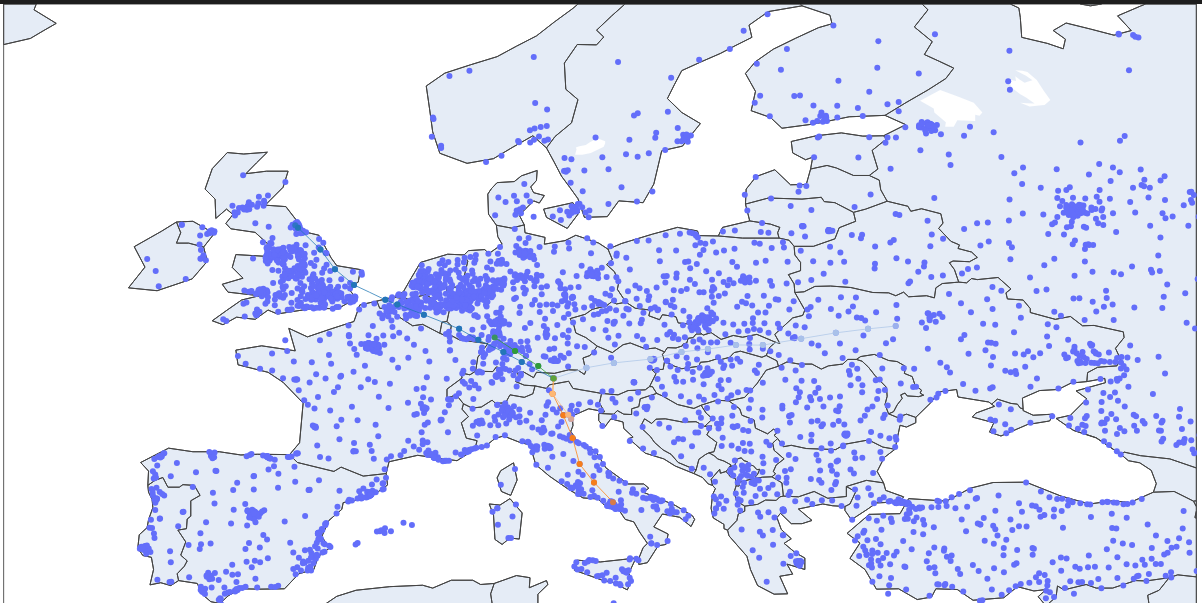

---
### Wiederholung für andere Reichweiten
Wiederholen Sie die Schritte für andere, selbstgewählte Reichweiten.  
Um die gleichen zufälligen Ziele zu verwenden, können Sie die Zelle mit der Zufallsauswahl erneut ausführen. Um besser nachvollziehen zu können was gerade passiert sehen Sie unten noch die Ausgabe einer möglichen Implementierung.

Tipp: Speichern Sie alle benötigten Outputs in einen DataFrame um die anschließende Visualisierung zu vereinfachen. Sie können aber auch eine andere Datenstruktur wählen.

In [ ]:
travel_ranges = [150, 200, 300, 400] #die hier angegebenen Reichweiten sind nur ein Vorschlag, Sie können auch andere Werte verwenden
output_data = []

for travel_range in travel_ranges:
    graph.remove_edges_from(list(graph.edges())) # alle Kanten entfernen und in der Lösung wieder für die aktuelle travel_range hinzufügen

    # Lösung hier einfügen
    for key, value in city_distances_dict.items():
        if value < travel_range:
            graph.add_edge(key[0], key[1], weight=value)
    
    for current_goal in random_goals:
        path_weighted = nx.shortest_path(graph, innsbruck, current_goal, weight="weight")
        path_weighted_length = get_length_from_path((path_weighted)) #type: ignore
        
        output_data.append({
            "travel_range": travel_range,
            "goal": current_goal.name,
            "path_stations": len(path_weighted) - 1,
            "path_length": path_weighted_length
        })
    # Ende der Lösung

output_df = pd.DataFrame(output_data)
print(output_df)
# Der Output der unten ausgegeben wird ist wieder nur ein Beispiel, Sie können auch andere Werte erhalten bzw. müssen nichts ausgeben

    travel_range         goal  path_stations  path_length
0            150       Shumen             13  1355.773001
1            150     Freising              1   129.562154
2            150      Granada             14  1702.674193
3            150     Lazdynai             11  1272.723303
4            150  Vladikavkaz             23  2702.354567
5            200       Shumen              9  1298.306355
6            200     Freising              1   129.562154
7            200      Granada             11  1688.280772
8            200     Lazdynai              9  1268.467846
9            200  Vladikavkaz             18  2671.025078
10           300       Shumen              6  1292.248146
11           300     Freising              1   129.562154
12           300      Granada              8  1663.094230
13           300     Lazdynai              5  1266.426813
14           300  Vladikavkaz             12  2645.190498
15           400       Shumen              4  1291.103460
16           4

---
### DataFrame mit Output Daten
So könnte Ihr DataFrame beispielsweise aussehen. Sie können Ihre Daten für die Visualisierung auch anders strukturieren, dies it nur eine mögliche Variante.

In [ ]:
display(output_df)

,travel_range,goal,path_stations,path_length
0,150,Shumen,13,1355.773001
1,150,Freising,1,129.562154
2,150,Granada,14,1702.674193
3,150,Lazdynai,11,1272.723303
4,150,Vladikavkaz,23,2702.354567
5,200,Shumen,9,1298.306355
6,200,Freising,1,129.562154
7,200,Granada,11,1688.280772
8,200,Lazdynai,9,1268.467846
9,200,Vladikavkaz,18,2671.025078


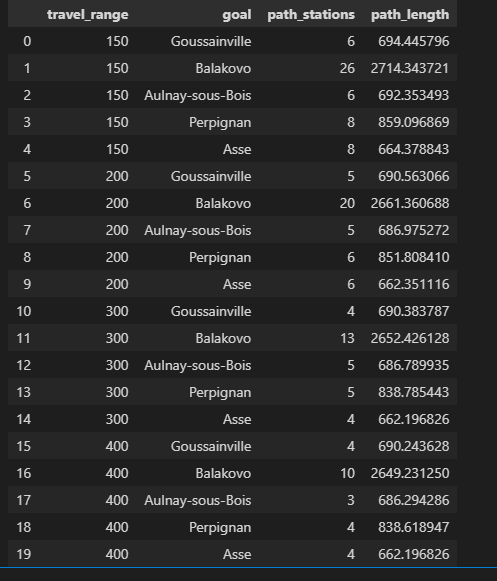

---
### Visualisierung der Ergebnisse für die unterschiedlichen Routen
Wir wollen uns mit Hilfe von Boxplots ansehen, wie sich die Anzahl der Stopps und die zurückgelegte Distanz für die unterschiedlichen Reichweiten verhält.  
Sie können dabei z.B. direkt die `boxplot(...)`-Methode Ihres DataFrames verwenden.

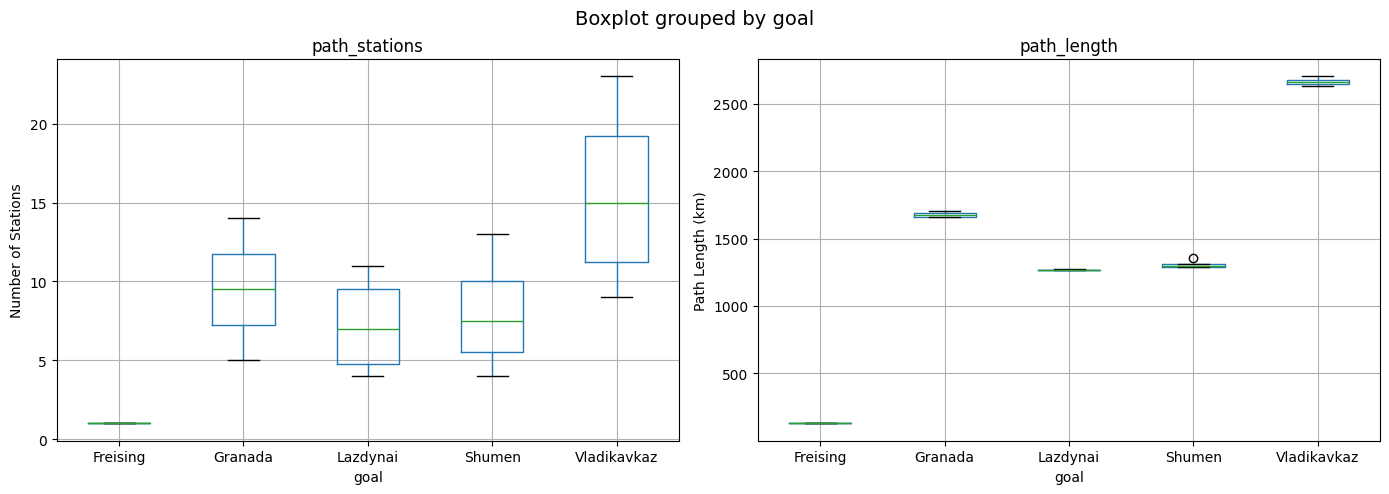

In [ ]:
# Lösung hier einfügen
# Die Boxplots müssen nicht identisch sein, sollen aber die gleiche Art an Informationen beinhalten

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

output_df.boxplot(column='path_stations', by='goal', ax=axes[0])
axes[0].set_title('path_stations')
axes[0].set_xlabel('goal')
axes[0].set_ylabel('Number of Stations')

output_df.boxplot(column='path_length', by='goal', ax=axes[1])
axes[1].set_title('path_length')
axes[1].set_xlabel('goal')
axes[1].set_ylabel('Path Length (km)')

fig.suptitle('Boxplot grouped by goal', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

plt.show()

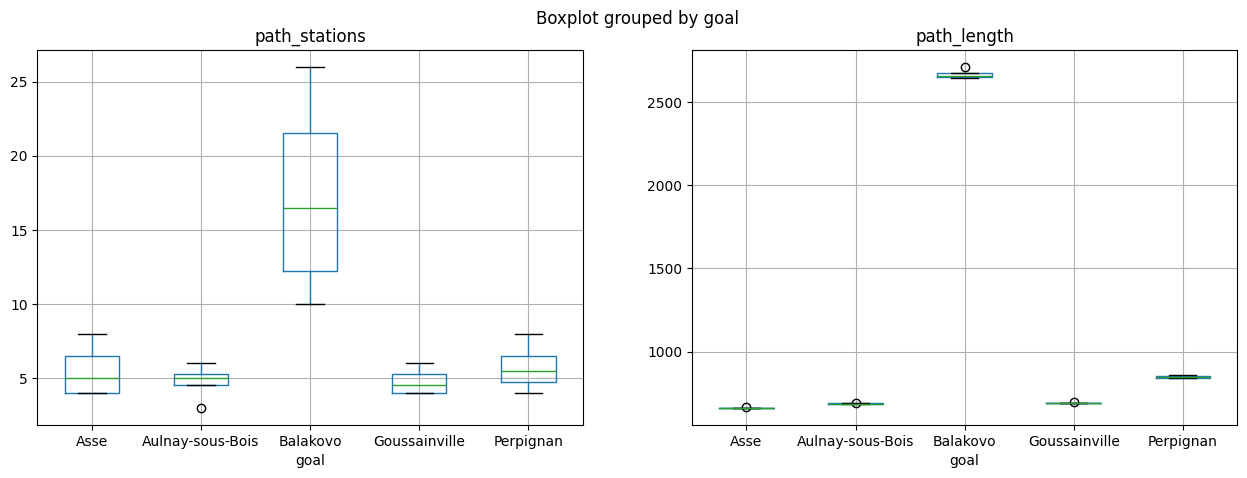

### Visualisierung der Ergebnisse für unterschiedliche Reichweiten
Es wird jeweils der Mittelwert an Stopps bzw. der Mittelwert der zurückgelegten Distanz für die 5 zufälligen Ziele visualisert.

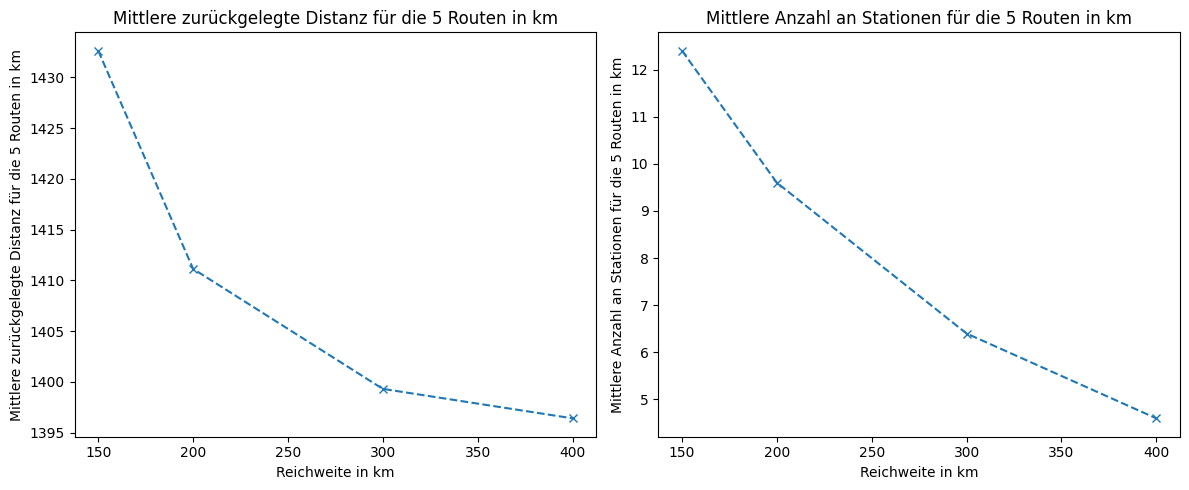

In [ ]:
# Lösung hier einfügen
# Die Plots müssen nicht identisch sein, sollen aber die gleiche Art an Informationen beinhalten

avg_df = output_df.groupby('travel_range').agg({
    'path_length': 'mean',
    'path_stations': 'mean'
}).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(avg_df['travel_range'], avg_df['path_length'], marker='x', linestyle='--')
axes[0].set_title('Mittlere zurückgelegte Distanz für die 5 Routen in km')
axes[0].set_xlabel('Reichweite in km')
axes[0].set_ylabel('Mittlere zurückgelegte Distanz für die 5 Routen in km')

axes[1].plot(avg_df['travel_range'], avg_df['path_stations'], marker='x', linestyle='--')
axes[1].set_title('Mittlere Anzahl an Stationen für die 5 Routen in km')
axes[1].set_xlabel('Reichweite in km')
axes[1].set_ylabel('Mittlere Anzahl an Stationen für die 5 Routen in km')

plt.tight_layout()

plt.show()

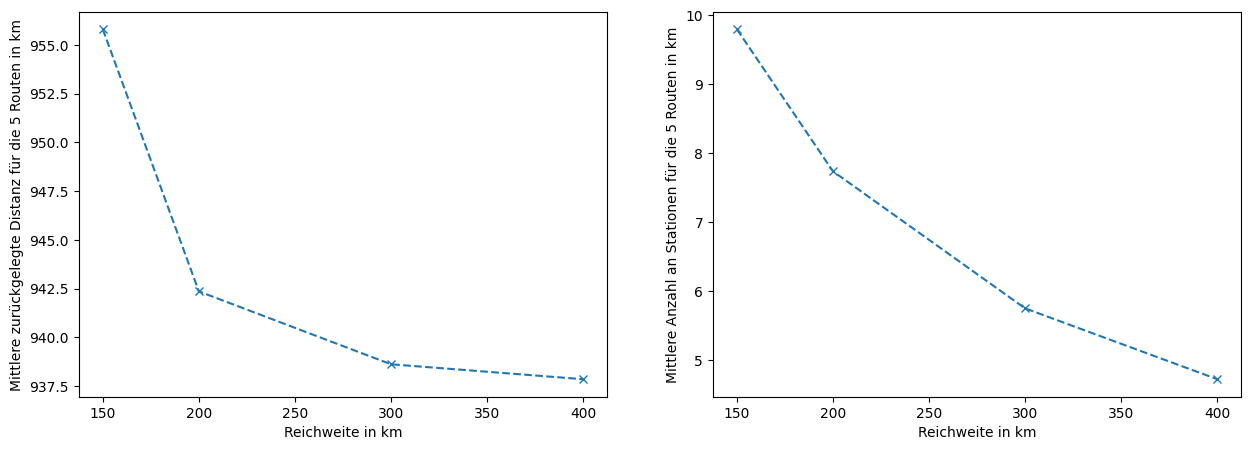